<a href="https://colab.research.google.com/github/AEW2015/fpga-colab/blob/main/xqrku060_FMECA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

AMD-Xilinx offers a Radiaiton Tolerant KU060 FPGA, but how often these devices fail and what is the effect of mitigation?


<figure>
    <img src="https://cf-images.us-east-1.prod.boltdns.net/v1/static/17209957001/321ccd1b-67b4-452a-a0a9-fc5586fdb87c/a3403ace-0540-42cc-a7e6-e042e5a7beb1/1280x720/match/image.jpg"
    width="450"
    alt="FT KU060">
    <figcaption>Caption Goes Here</figcaption>
</figure>

TODO:
* ~~add pictures~~
    * ~~Add Placement Picture~~
* ~~point to publications~~
    * ~~Links for docs and tools~~
* ~~point to other examples~~
* Have a small story between sections
* Update all comments
* Highlight talking points


Quick points:
*   Using Public Vendor Heavy Ion Data
*   Vendor, Public, and Opensource Tools and designs
*   Map data to an orbit for failures for a specific designs



Assumptions will be listed, but can be changed to match your situation:
*   [DS882](https://docs.xilinx.com/v/u/en-US/ds882-xqr-kintex-ultrascale) Weibull Fit Curves, and SEFI rates
*   [Spenvis](https://www.spenvis.oma.be/) with listed configs
*   GEO orbit
*   100 mills of aluminum shiledling
*   Simple CRAM Scrubbing (only look at Single CRAM events)
*   No data for freqnecy-based SETI upsets
*   [BYU SpyDrNet TMR Tools](https://github.com/byuccl/spydrnet-tmr/tree/main)
*   Other assumptions listed below



# Orbit Upset Rates

![Spenvis logo](https://www.spenvis.oma.be/images/spenvislogo.gif)

Spenvis Config:
1.  Orbit is geostionary, 1 day orbit, longitude 0, Jan 2020 Launch
2.  Solar Partiacl Fluex CREMA-96, H to U, Wort Week, Mag Shield (quiet)
3. Short-Term SEU rate, 0.254 cm Shield, Si (CREME-86), x*y = 0.0004 um, z = 2 um
4. Heavy Ion Weibull Funciton



In [ ]:
CRAM_bit_day    = 5.5132E-09
BRAM_bit_day    = 7.8714E-09
SLR_device_day  = 1.1775E-03
CNT_device_day  = 7.6083E-04
DSP_device_day  = 1.3997E-03
GTH_device_day  = 9.0687E-05
IOB_device_day  = 1.9342E-03
PLL_device_day  = 4.9828E-05
MMCM_device_day = 4.9828E-05
SEFI_device_day = 4.5e-4

# Device Failures

<figure>
    <img src="https://www.xilinx.com/content/xilinx/en/products/silicon-devices/fpga/rt-kintex-ultrascale/_jcr_content/root/imageTabParsys/childParsys-productAdvantages/xilinxcolumns/childParsys-1/xilinximage.img.png/1684954227147.png"
    width="350"
    alt="FPGA Layout">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Apply this to the Whole device:

*   Full Bitstream is 192,999,264 bits:
  * CRAM is 153186144 bits (type 0 frames)
  * BRAM is 39813120 bits (type 1 frames)



In [ ]:
CRAM_device_day = CRAM_bit_day * 153186144
BRAM_device_day = BRAM_bit_day * 39813120

In [ ]:
Full_device_day = CRAM_device_day + BRAM_device_day + SLR_device_day + CNT_device_day + DSP_device_day \
                + GTH_device_day + IOB_device_day + PLL_device_day + MMCM_device_day + SEFI_device_day
print("FPGA will see a device failure every {0:0.4} hours".format(24/Full_device_day))

FPGA will see a device failure every 20.62 hours


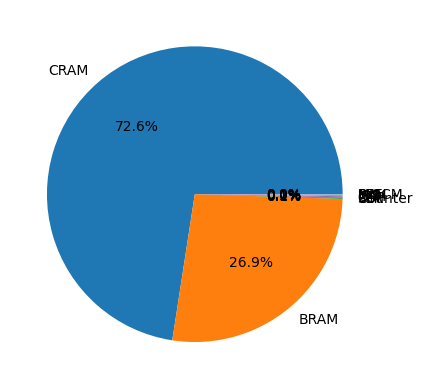

In [ ]:
import matplotlib.pyplot as plt

labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_device_day, BRAM_device_day, SLR_device_day, CNT_device_day,DSP_device_day,\
         GTH_device_day,IOB_device_day,PLL_device_day,MMCM_device_day,SEFI_device_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

# Embedded Processors

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/306e7102c922abd010baf5a1a957f9617bd647da/3-Figure2-1.png"
    width="350"
    alt="Proc Tiles">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Example Design Build: [Source](https://github.com/AEW2015/fpga-colab/tree/main/FIG/digilent_arty/dut)

## Design Failures

What is the design?

Fault Injection Example:
[ipynb](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/fault_injection/arty_a7_fault_injection.ipynb)

Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with features not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
      * difficult to simulate for more detailed analysis
* Everything else based on utilization


In [ ]:
CRAM_senstivity = .0551
nFIFO_BRAM = .702
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .117
GTH_util = 0 # Not used
IOB_util = 2 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 6.362288481320409 days


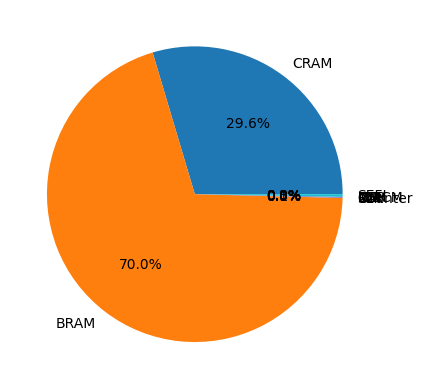

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Mitigated Design

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/306e7102c922abd010baf5a1a957f9617bd647da/2-Figure1-1.png"
    width="350"
    alt="TMR Application">
    <figcaption>Caption Goes Here</figcaption>
</figure>

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/3-Figure2-1.png"
    width="350"
    alt="TMR Voters">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Example Python TMR Flow: [ipynb](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/tmr/digilent_arty_SpyDrNet_TMR.ipynb)

Example Build TCL script: [TCL](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/tmr/build_tmr.tcl)

Another Python Example: [ipynb](https://github.com/AEW2015/fpga-colab/blob/main/SpyDrNet_TMR_examples.ipynb)

New TMR design!
Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 0.412% sensitivity for TMR BRAM (see Apendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [ ]:
CRAM_senstivity = .00079
nFIFO_BRAM = .476
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .117
GTH_util = 0 # Not used
IOB_util = 2 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 1.908091985845966 Year


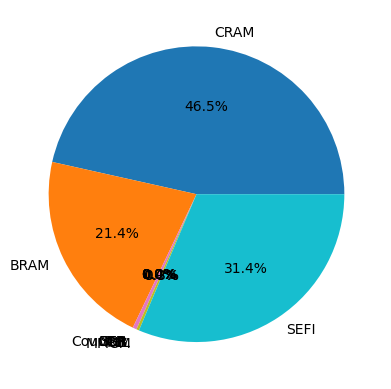

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Compare to Radiation Data

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/306e7102c922abd010baf5a1a957f9617bd647da/4-Figure3-1.png"
    width="350"
    alt="Rad Testing">
    <figcaption>Caption Goes Here</figcaption>
</figure>

In [ ]:
nTMR_NEU_MFTF = 1/ 5.96E-08 # 1/ cross-section
TMR_NEU_MFTF = 1 / 5.58E-10 # 1/ cross-section

In [ ]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

109.54086723298035 106.8100358422939


In [ ]:
nTMR_processor_count = 117
TMR_processor_count = 28
nTMR_norm_perf = 1
TMR_norm_perf = 0.93

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

24.379864809801784 23.772079772079774


### Publication for more info: [IEEE](https://ieeexplore.ieee.org/document/10012379)

# Soft Linux SoC Processor


<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/2-Figure1-1.png"
    width="650"
    alt="VexRiscv LiteX Config">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Example LiteX Gen:

F4PGA LiteX Arty [link](https://github.com/AEW2015/fpga-colab/blob/main/F4PGA_Litex_Arty.ipynb)

Linux on LiteX Repo: [link](https://github.com/litex-hub/linux-on-litex-vexriscv) (supports most dev boards)

## Design Failures

What is the design?

Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [ ]:
CRAM_senstivity = .0057
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0054
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 61.2078058303423 days


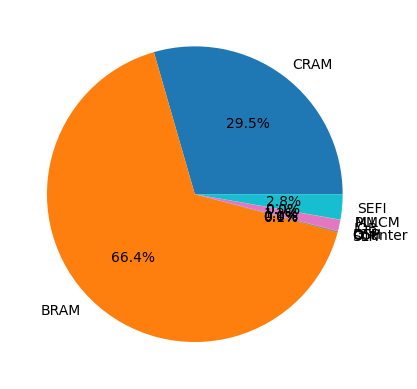

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Mitigated Design

New TMR design!
Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 4.12E-3 sensitivity for BRAM (see Apendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [ ]:
CRAM_senstivity = .00039
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.450636114889419 Year


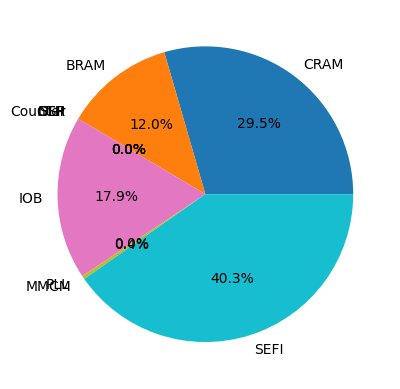

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Compare to Radiation Data

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/4-Figure5-1.png"
    width="350"
    alt="VexRiscv LiteX Rad Test">
    <figcaption>Caption Goes Here</figcaption>
</figure>

In [ ]:
nTMR_NEU_MFTF = 1/ 2.09E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.42E-10 # 1/ cross-section

In [ ]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

14.62386747606036 14.71830985915493


In [ ]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

11.845332655608892 11.921830985915493


### Publication for more info: [IEEE](https://ieeexplore.ieee.org/document/9386126)

# Bitstream Fault Analysis

[BFAT github](https://github.com/byuccl/bfat)

Small Introduction with pic!

<figure>
    <img src="https://github.com/byuccl/bfat/raw/main/bfat_flowchart.png"
    width="450"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

BFAT Examples:

[Embedded Proccessor](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/digilent_arty_BFAT.ipynb)

[Litex Example](https://github.com/AEW2015/fpga-colab/blob/main/BFAT_Litex_example.ipynb)

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/8-Table4-1.png"
    width="450"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

```======================================================================
                             Bit Group 28
======================================================================

Significant Bits:
------------------------------
bit_00402b84_87_1 (0->1)
	INT_R_X87Y143 - WW4BEG0 2-20 Routing Mux - Column Bit
	Resource Design Name: INT_R_X87Y143/WW4BEG0
	Shorts formed between net(s): ISERDESE2_13_n_8 (initially connected), Unconnected Wire(SW6END_N0_3)
	Affected PIPs:
		SW6END_N0_3->>WW4BEG0 (activated)
	Affected Resources:
		VexRiscvLitexSmpCluster_Cc1_Iw32Is4096Iy1_Dw32Ds4096Dy1_ITs4DTs4_Ldw128_Ood/dBridge_logic/io_output_rdata_fifo/storage_12_reg_6_i_10_TMR_2
		main_a7ddrphy_bitslip13_r1_reg_TMR_0[8]
		main_a7ddrphy_bitslip13_r1_reg_TMR_1[8]
		main_a7ddrphy_bitslip13_r1_reg_TMR_2[8]

	Vivado Tcl Commands:
		select_objects [get_pips {INT_R_X87Y143/INT_R.SW6END_N0_3->>WW4BEG0}]
		select_objects [get_nets {ISERDESE2_13_n_8}]
		select_objects [get_cells {VexRiscvLitexSmpCluster_Cc1_Iw32Is4096Iy1_Dw32Ds4096Dy1_ITs4DTs4_Ldw128_Ood/dBridge_logic/io_output_rdata_fifo/storage_12_reg_6_i_10_TMR_2 main_a7ddrphy_bitslip13_r1_reg_TMR_0[8] main_a7ddrphy_bitslip13_r1_reg_TMR_1[8] main_a7ddrphy_bitslip13_r1_reg_TMR_2[8]}]
```

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/9-Figure11-1.png"
    width="750"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

### Publication for more info: [ACM](https://dl.acm.org/doi/10.1145/3543622.3573191)

# TMR with Placement guides


## Design Failures

What is the design?

Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [ ]:
CRAM_senstivity = .0057
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0054
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 61.2078058303423 days


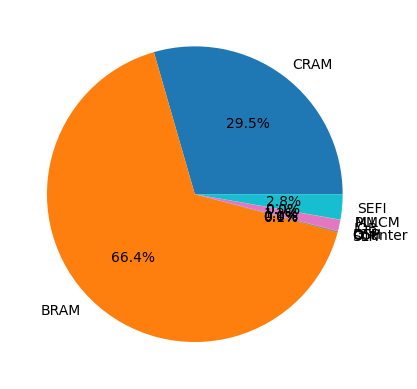

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Mitigated Design

Output Voters:

```
create_pblock poserd_0
add_cells_to_pblock [get_pblocks poserd_0] [get_cells -quiet [list \
    OSERDESE2_38_i_1_TMR_0_O_VOTER OSERDESE2_38_i_2_TMR_0_O_VOTER  \
    OSERDESE2_38_i_3_TMR_0_O_VOTER OSERDESE2_38_i_4_TMR_0_O_VOTER]]
resize_pblock [get_pblocks poserd_0] -add {SLICE_X162Y194:SLICE_X163Y199}
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/oserdes.png?raw=true"
    width="950"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Input Flip-Flops
```
create_pblock piserd_0
add_cells_to_pblock [get_pblocks piserd_0] [get_cells -quiet [list \
    main_a7ddrphy_bitslip0_r3_reg_TMR_0[15] \
    main_a7ddrphy_bitslip0_r3_reg_TMR_2[15] \
    main_a7ddrphy_bitslip0_r3_reg_TMR_2[15]]]
resize_pblock [get_pblocks piserd_0] -add {SLICE_X162Y180:SLICE_X163Y185}
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/iserdes.png?raw=true"
    width="950"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

Stripping:
```
create_pblock pblock_dut_tmr_0
resize_pblock [get_pblocks pblock_dut_tmr_0] -add {
    SLICE_X0Y0:SLICE_X1Y249
    SLICE_X6Y0:SLICE_X7Y249
    ...
    SLICE_X96Y0:SLICE_X97Y249
    SLICE_X102Y0:SLICE_X103Y249
}
set_property IS_SOFT 0 [get_pblocks pblock_dut_tmr_0]
add_cells_to_pblock [get_pblocks pblock_dut_tmr_0] \
    [get_cells -hierarchical -regexp .*TMR(_VOTER)?_0.* -filter IS_PRIMITIVE==1]
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/pbtmr.png?raw=true"
    width="450"
    alt="BFAT Flow">
    <figcaption>Caption Goes Here</figcaption>
</figure>

New TMR design!
Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 4.12E-3 sensitivity for BRAM (see Apendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

Point out CRAM senstivity dropped by 3x!

In [ ]:
CRAM_senstivity = .00013
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 3.0501286701350017 Year


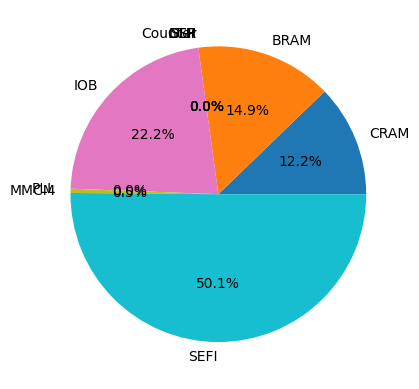

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Compare to Radiation Data

<figure>
    <img src="https://ccl.byu.edu/images/news_2022/lansce_experiments.jpg"
    width="750"
    alt="VexRiscv LiteX Par Rad Test">
    <figcaption>Caption Goes Here</figcaption>
</figure>

In [ ]:
nTMR_NEU_MFTF = 1/ 2.59E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.14E-10 # 1/ cross-section

In [ ]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

18.201265045422378 22.719298245614034


In [ ]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

14.743024686792127 18.40263157894737


# TMR with DDR EDAC


<figure>
    <img src="https://antmicro.com/images/05-09-01-lpddr4-hero.png"
    width="750"
    alt="VexRiscv LiteX Par Rad Test">
    <figcaption>Caption Goes Here</figcaption>
</figure>

## Design Failures

What is the design?

Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [ ]:
CRAM_senstivity = .01274
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0067
GTH_util = 0 # Not used
IOB_util = 138 /620 # UART only
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 44.416831373210684 days


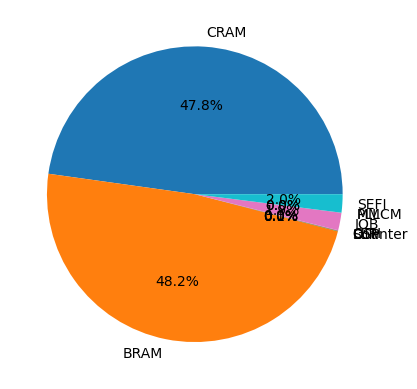

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Mitigated Design

New TMR design!
Assumptions:
*   CRAM Senstivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "senstivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 4.12E-3 sensitivity for BRAM (see Apendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [ ]:
CRAM_senstivity = .00035
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0301
GTH_util = 0 # Not used
IOB_util = 75 /620 # Reduce IO since Data pins are protected
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.45402225473117 Year


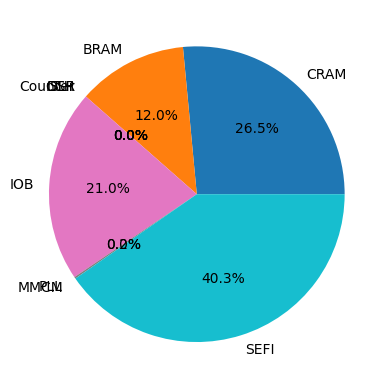

In [ ]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## Compare to Radiation Data

In [ ]:
nTMR_NEU_MFTF = 1/ 3.82E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.93E-10 # 1/ cross-section

In [ ]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

20.179999356756642 19.792746113989637


In [ ]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

16.345799478972882 16.032124352331607


# Dont forget DDR Failure Rates

<figure>
    <img src="https://www.3d-plus.com/app/uploads/2023/04/3D4D48G48LB2825.png.webp" width="250" alt="3Dplus Memory">
    <figcaption>Caption Goes Here</figcaption>
</figure>

## Placement with SDRAM DDR

In [ ]:
CRAM_senstivity = .00013
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
# Example with critical charge
DDR_bit_day = 7.0531E-12
# Same as BRAM for quick estimate
DDR_senstivity_estimate = 0.5
# go for 16Gb (2GB)
DDR_device_day = 1024 * 1024 * 1024 * 16 * DDR_bit_day * DDR_senstivity_estimate

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day + DDR_device_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 16.264582918866775 days


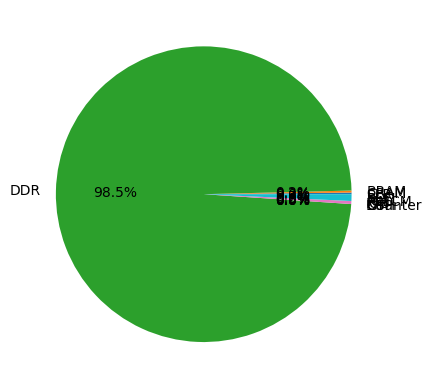

In [ ]:
labels = 'CRAM', 'BRAM', 'DDR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI','SLR'
sizes = [CRAM_design_day, BRAM_design_day, DDR_device_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day,SLR_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## DDR ECC with SDRAM DDR

In [ ]:
CRAM_senstivity = .00035
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0301
GTH_util = 0 # Not used
IOB_util = 75 /620 # UART only
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [ ]:
BRAM_senstivity_estimate = 0.5
BRAM_TMR_senstivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_senstivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_senstivity_estimate * BRAM_TMR_senstivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [ ]:
# Example with critical charge
DDR_bit_day = 7.0531E-12
# Same as BRAM for quick estimate
DDR_senstivity_estimate = 0.5
# Simple ECC estimate (same as BRAM TMR), but probably much better
DDR_ECC_senstivity_estiamte = 0.00411983113735914
# go for 16GB
DDR_device_day = 1024 * 1024 * 1024 * 16 * DDR_bit_day * DDR_senstivity_estimate * DDR_ECC_senstivity_estiamte

In [ ]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day + DDR_device_day
print("FPGA will see a design failure every {0} years".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.0053677253668956 years


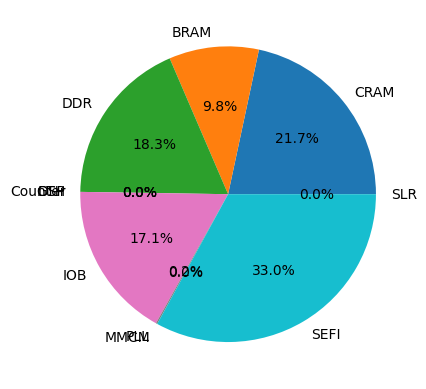

In [ ]:
labels = 'CRAM', 'BRAM','DDR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI','SLR'
sizes = [CRAM_design_day, BRAM_design_day, DDR_device_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day,SLR_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

## What About MRAM external memory?

There are other options besdies SDRAM DDR that perform much better in space enviroments.



<figure>
    <img src="https://b1967244.smushcdn.com/1967244/wp-content/uploads/consolidation-with-8Gb-v2.png"
    width="750"
    alt="MRAM Memory">
    <figcaption>Caption Goes Here</figcaption>
</figure>

# Reaching Full Fault Tolerance

* CRAM -> TMR placement to reduce senstivity to 0.01%
* BRAM -> EDAC with scrubbing to greatly reduce sensitvity
* DDR/IO -> Protocols to protect Data, Addr, Cmd
    *  3Dplus Radiation Intelligent Memory Controller (RMIC)
        * Reed Solomon
        * Addr/Cmd Parity
* External Devices -> Select MRAM or FDSOI memories
    * Avalanche MRAM
    * 3Dplus MNEMOSYNE

In [84]:
Other_design_day = 1E-4
Full_design_day =  SEFI_design_day+Other_design_day
print("FPGA will see a design failure every {0} years".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 4.977910522058366 years


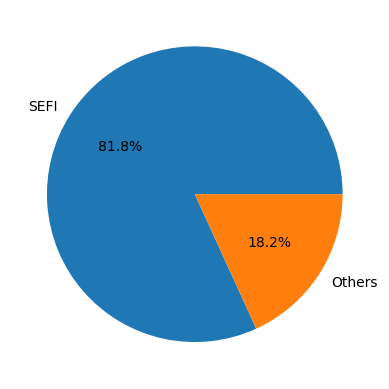

In [85]:
labels = 'SEFI','Others'
sizes = [SEFI_design_day,Other_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

For the xqrKU060, the SEFI quickly becomes the limiting factor for fault tolerance.  If you need better MTTF, then other technologies need to be considered.

If you can allow for "down time", MTTF from 7 days to 5 years may be enough.

If you need critical function over a window that can't abort, a MTTF of 5 years may not be enough.


For Heavy Ion Data,
* AMD Versal AI Edge 2302 will likely get up to __100__ years with the same design.
* MicrChip RTG4 will likely get up to __1000__ years with the same design.

Summary:
*   Understand Orbit data and SEE rates
*   Perform Fault Injection
*   Trace Fault dependences and consequnces
*   Identify Critical Single-point failrues
*   Provide targeted mitigation to help

# BRAM TMR Senstivity Appendix

## Model

Some quick math to get a "close" value, check later with simulation

In [86]:
from sympy import symbols, binomial
# Calculating the probability that exactly 2 out of 3 bits fail for 3 32Kb BRAMs
p_value = 1/(3*32*1024) #
P_X_equals_2_value = binomial(3, 2) * (p_value**2) * ((1-p_value)**(3-2))

P_X_equals_2_value

3.10437700237445e-10

In [87]:
P_X_equals_2_value * 32 * 1024 * 405

0.00411983113735914

## TMR BRAM Simulation

Our Model value is about 5% below the median of TMR BRAM failures.
It seems to be a good conserative value.

In [89]:
import numpy as np
k32 = 32*1024
k96 = 96*1024
p96 = 1/k96
pbgeo = 0.0000000078773

In [93]:
#reset array
nTMR = []
TMR = []

In [94]:
for sims in range(0,300):
  print("### ",sims," ###")
  TMR_a = np.zeros(k32, dtype=bool)
  TMR_b = np.zeros(k32, dtype=bool)
  TMR_c = np.zeros(k32, dtype=bool)
  pbgeoALL = pbgeo * 405 #simulate whole device and quicker testing
  time = 0
  flag_a = 0
  flag_b = 0
  flag_c = 0
  goto = 0
  while goto == 0:
    SEU_a = np.random.binomial(1,pbgeoALL,k32)
    SEU_b = np.random.binomial(1,pbgeoALL,k32)
    SEU_c = np.random.binomial(1,pbgeoALL,k32)
    TMR_a = TMR_a | SEU_a
    TMR_b = TMR_b | SEU_b
    TMR_c = TMR_c | SEU_c




    time += 1

    if (time%100 == 0):
      acount = 0
      bcount = 0
      ccount = 0
      for av, bv ,cv in zip(TMR_a , TMR_b, TMR_c):
        if av == 1:
          acount += 1
        if bv == 1:
          bcount += 1
        if cv == 1:
          ccount += 1
      print(time," counts ",acount,bcount,ccount)




    if ((TMR_a == 1 ).any() == True) and flag_a == 0:
        print ("A ",time)
        nTMR.append(time)
        flag_a = 1
    if ((TMR_b == 1 ).any() == True) and flag_b == 0:
        print ("B ",time)
        nTMR.append(time)
        flag_b = 1
    if ((TMR_c == 1 ).any() == True) and flag_c == 0:
        print ("C ",time)
        nTMR.append(time)
        flag_c = 1
    for av, bv ,cv in zip(TMR_a , TMR_b, TMR_c):
      if (av == 1) and (bv ==1):
        print ("A&B ",time)
        TMR.append(time)
        goto = 1
      if (av == 1) and (cv ==1):
        print ("A&C ",time)
        TMR.append(time)
        goto = 1
      if (cv == 1) and (bv ==1):
        print ("C&B ",time)
        TMR.append(time)
        goto = 1
  print("=== Results ===")
  nTMRCount = (len(nTMR))
  TMRCount = (len(TMR))
  nTMRFailRate = (sum(nTMR) / len(nTMR))
  TMRFailRate = (sum(TMR) / len(TMR))
  Senstivity = nTMRFailRate/TMRFailRate
  model = 0.00411983113735914
  SenstivityDiff = (Senstivity - model)/model
  print(nTMRCount,TMRCount,nTMRFailRate,TMRFailRate,Senstivity,SenstivityDiff)
  is_above = 0
  limit = 1/(model*0.31361989)
  for tmrv in TMR:
    if tmrv >= limit:
      is_above += 1
  is_above_percent = is_above/TMRCount
  print(is_above_percent)
print(nTMR)
print(TMR)

###  0  ###
A  2
C  9
B  14
100  counts  10 11 10
200  counts  20 24 23
300  counts  31 34 29
400  counts  43 49 42
500  counts  54 57 53
600  counts  67 72 64
700  counts  77 82 74
800  counts  89 94 84
900  counts  106 101 93
1000  counts  115 112 102
1100  counts  120 120 117
C&B  1144
=== Results ===
3 1 8.333333333333334 1144.0 0.007284382284382285 0.7681264210871661
1.0
###  1  ###
A  5
C  14
B  38
100  counts  10 7 7
200  counts  18 20 22
300  counts  27 29 31
400  counts  35 34 40
500  counts  46 45 44
600  counts  55 56 55
700  counts  59 67 64
800  counts  70 80 74
900  counts  82 93 85
1000  counts  94 104 94
1100  counts  109 110 100
C&B  1145
=== Results ===
6 2 13.666666666666666 1144.5 0.011941167904470655 1.8984605209147198
1.0
###  2  ###
C  5
A  22
B  27
100  counts  7 5 10
200  counts  15 11 23
300  counts  22 21 36
400  counts  33 31 52
500  counts  45 41 63
600  counts  54 53 70
700  counts  66 67 80
A&C  702
=== Results ===
9 3 15.11111111111111 997.0 0.0151565808